# Dimensionality Reduction

This notebook explores the Ondřejov dataset using PCA and t-SNE
and some preprocessing algorithms.

In [1]:
%matplotlib nbagg

In [2]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.decomposition import PCA
import sklearn.preprocessing
import matplotlib
import matplotlib.pyplot as plt
import spectraldl.ondrejov as ondrejov
import astropy.io.fits as fits
from astropy.convolution import Gaussian1DKernel, convolve

In [3]:
with h5py.File('data/data.hdf5') as f:
    X = f['X'][...]
    y = f['y'][...]

In [7]:
def plot_scatter(X, y):
    '''Plot scatter plot of point from X. X is of shape (n_samples, 2).'''
    fig, ax = plt.subplots()
    sc = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.25)
    fig.colorbar(sc)

## PCA

Reduce the raw dataset to 2 PCA compenents.
Explained variance is high
but the scatter plot shows that this reduction is useless
because most of the point are close to each other.

explained variance: 97.85830824431163%


<IPython.core.display.Javascript object>


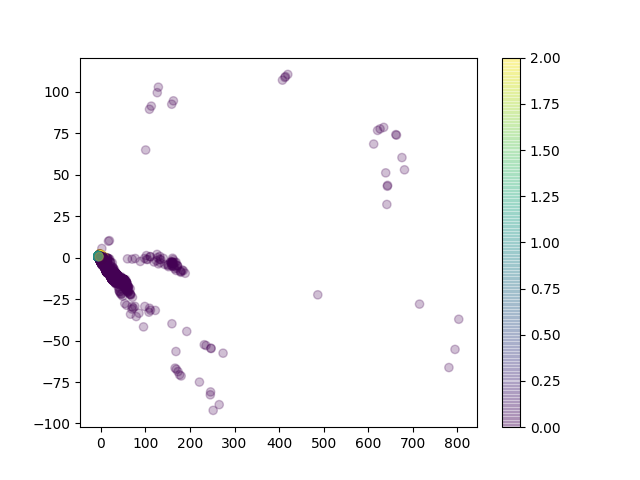

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print('explained variance: {}%'.format(np.sum(pca.explained_variance_ratio_) * 100))
plot_scatter(X_pca, y)

<IPython.core.display.Javascript object>


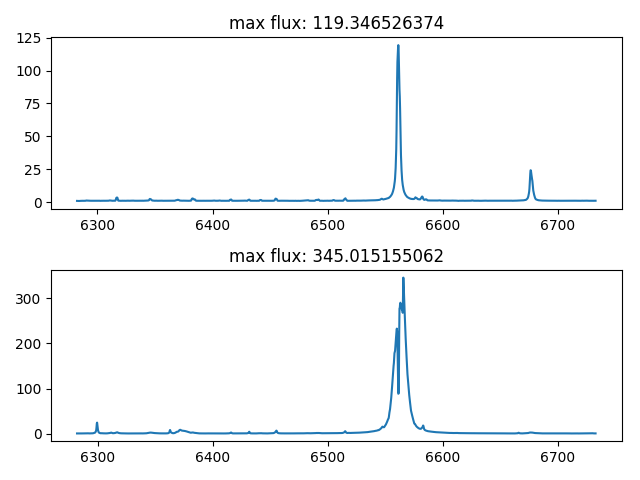

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1)

with fits.open('ssap/ui300025.fits') as hdulist:
    ondrejov.plot_spectrum(hdulist, ax1)
    ax1.set_title('max flux: ' + str(np.max(ondrejov.get_fluxes(hdulist))))

with fits.open('ssap/td260020.fits') as hdulist:
    ondrejov.plot_spectrum(hdulist, ax2)
    ax2.set_title('max flux: ' + str(np.max(ondrejov.get_fluxes(hdulist))))

fig.tight_layout()

If identificator are plotted to the scatter plot
the outliers can be determined.
Two of them are plotted above.
They have really high some fluxes values.

### Scaling Samples

But because in this classfication problem the shape of spectral is the most important
the fluxes intensities can be suppress to some range.

In following code minmax scaler and scaler to zero mean and unit variance are applied
to **each individula spectra**. ATTENTION not applied to each feature.

Aim is to suppress intensieties and so only information about shape remains.

<IPython.core.display.Javascript object>


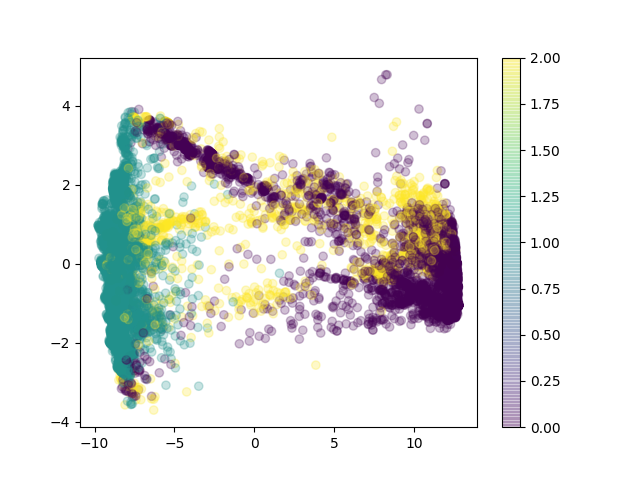

In [10]:
# minmax scale to range (-1, 1)
# axis=1 means to scale individual samples
X_minmax = sklearn.preprocessing.minmax_scale(X, feature_range=(-1, 1), axis=1)
X_minmax_pca = PCA(n_components=2).fit_transform(X_minmax)
plot_scatter(X_minmax_pca, y)

<IPython.core.display.Javascript object>


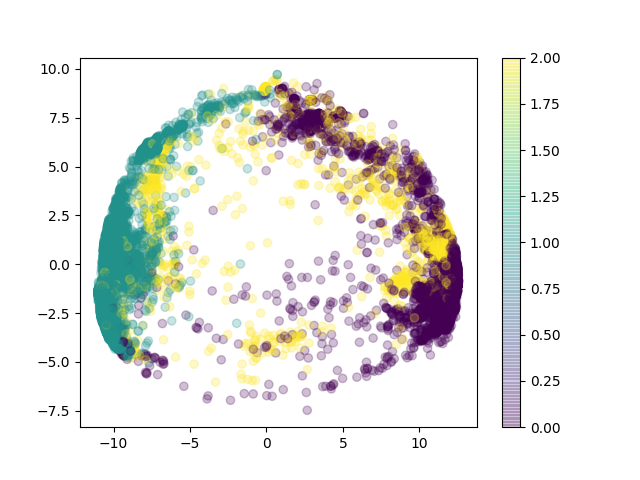

In [11]:
X_scale = sklearn.preprocessing.scale(X, axis=1)
X_scale_pca = PCA(n_components=2).fit_transform(X_scale)
plot_scatter(X_scale_pca, y)

<IPython.core.display.Javascript object>


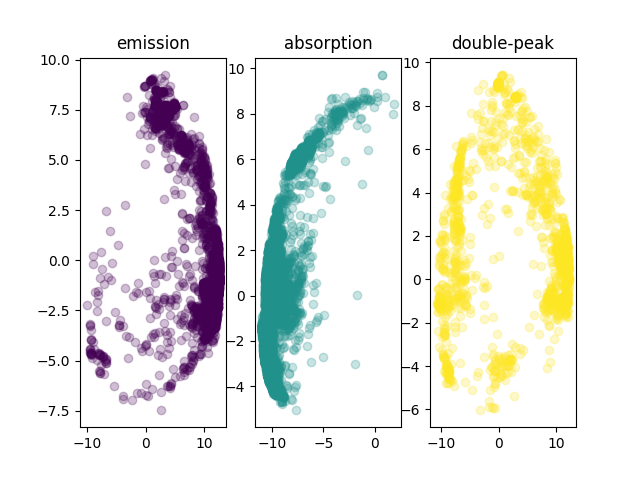

In [13]:
# each class plotted individually
cmap = plt.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
fig, axs = plt.subplots(1, 3)

titles = ['emission', 'absorption', 'double-peak']
labels = [0, 1, 2]
colors = [cmap(norm(l)) for l in labels]
for title, label, ax, color in zip(titles, labels, axs, colors):
    ax.set_title(title)
    ax.scatter(X_scale_pca[y == label][:, 0], X_scale_pca[y == label][:, 1], alpha=0.25, c=color)

### Conclusions

Result above are much more promising.
From scatter plot it look relatively easy to separate emission an absorption spectra.
But double-peak spectra are mix randomly in space.
They are maybe better separated when scaled to zero mean and unit varinace.

If we should split to emission and absorption linear separation would work good.
But because the double-peak spectra are not easily separable in above plot
deep network will hopefully find better representation for sepation.

The insight into data then the shape is the main feature helps to
apply dimensionality reduction better therefore it should be used futher.

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print('explained variance: {}%'.format(np.sum(pca.explained_variance_ratio_) * 100))

X_scale = sklearn.preprocessing.scale(X, axis=1)
scale_pca = PCA(n_components=2)
X_scale_pca = scale_pca.fit_transform(X_scale)
print('explained variance: {}%'.format(np.sum(scale_pca.explained_variance_ratio_) * 100))

explained variance: 97.8583082443116%
explained variance: 86.73363361684106%


<IPython.core.display.Javascript object>


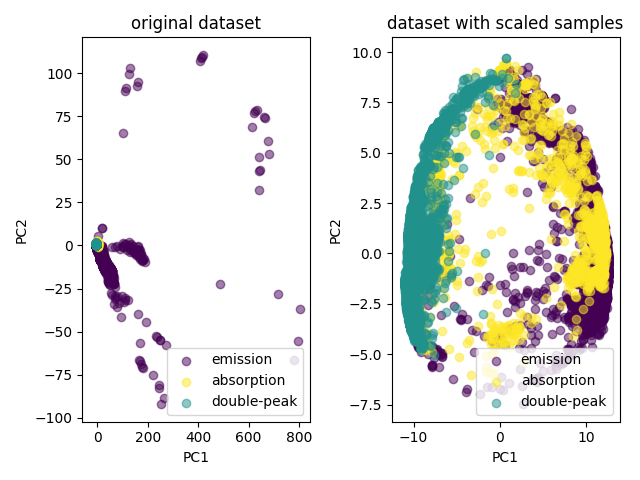

In [15]:
# publication plot
fig, (ax1, ax2) = plt.subplots(1, 2)

cmap = plt.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)

for label, name in zip([0, 2, 1], ['emission', 'absorption', 'double-peak']):
    idx = y == label
    color = cmap(norm(label))
    ax1.scatter(X_pca[:, 0][idx], X_pca[:, 1][idx], c=color, alpha=0.5, label=name)
    ax2.scatter(X_scale_pca[:, 0][idx], X_scale_pca[:, 1][idx], c=color, alpha=0.5, label=name)

ax1.set_title('original dataset')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend(loc='lower right')

ax2.set_title('dataset with scaled samples')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.legend(loc='lower right')

fig.tight_layout();

### Scaling Features

Almost same as previous code. Just remove `axis=1`.
Conclusion is that the same really matters.

<IPython.core.display.Javascript object>


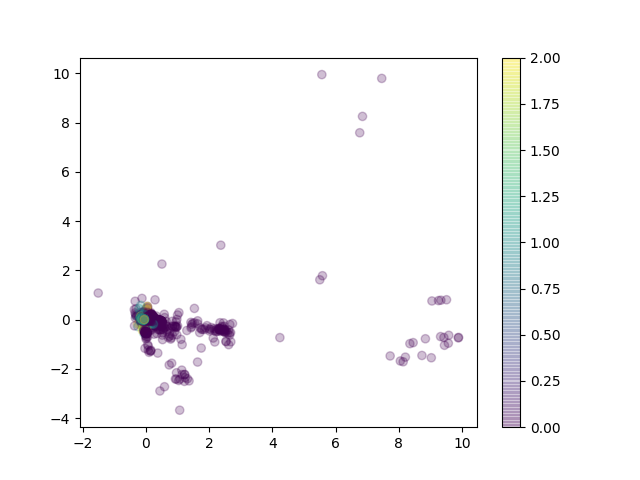

In [17]:
# minmax scale to range (-1, 1)
X_f_minmax = sklearn.preprocessing.minmax_scale(X, feature_range=(-1, 1))
X_f_minmax_pca = PCA(n_components=2).fit_transform(X_f_minmax)
plot_scatter(X_f_minmax_pca, y)

<IPython.core.display.Javascript object>


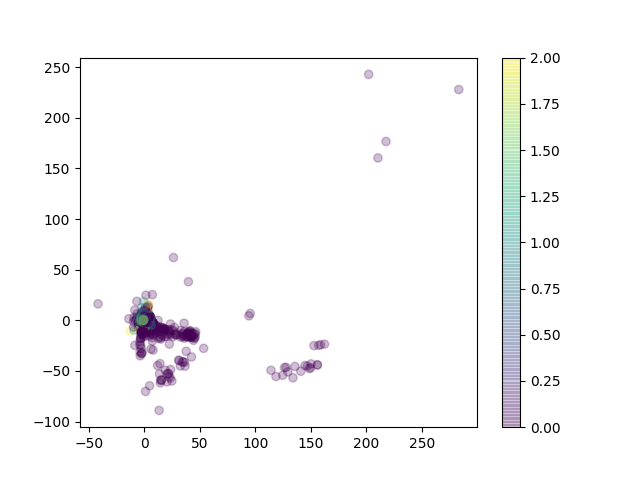

In [19]:
X_f_scale = sklearn.preprocessing.scale(X)
X_f_scale_pca = PCA(n_components=2).fit_transform(X_f_scale)
plot_scatter(X_f_scale_pca, y)

## t-SNE

In [24]:
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

# with high number of sapmles scikit learn crashes with MemoryError
X_, y_ = shuffle(X_scale, y)
X_, y_ = X_[:5000], y_[:5000]

In [33]:
X_pca = PCA(n_components=2).fit_transform(X_)

tsne = TSNE(
    #n_components=2, # 2D out array
    #perplexity=50, # should be 5-50
    #learning_rate=100, # should be 100-1000
    #n_iter=5000, # max number of iterations
    init='pca', # start with PCA position
    verbose=2,
)
X_tsne = tsne.fit_transform(X_)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.548227
[t-SNE] Iteration 25: error = 1.3812340, gradient norm = 0.0036087
[t-SNE] Iteration 50: error = 1.3293715, gradient norm = 0.0031438
[t-SNE] Iteration 75: error = 1.1176060, gradient norm = 0.0017843
[t-SNE] Iteration 100: error = 1.0708374, gradient norm = 0.0015714
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.070837
[t-SNE] Iteration 125: error = 0.9907994, gradient norm = 0.0012907
[t-SNE] Iteration 150: error = 0.9651111, gradient norm = 0.0012145
[t-SNE] Iteration 175: error = 0.9586426, gradient norm = 0.0011966
[t-SNE] I

<IPython.core.display.Javascript object>


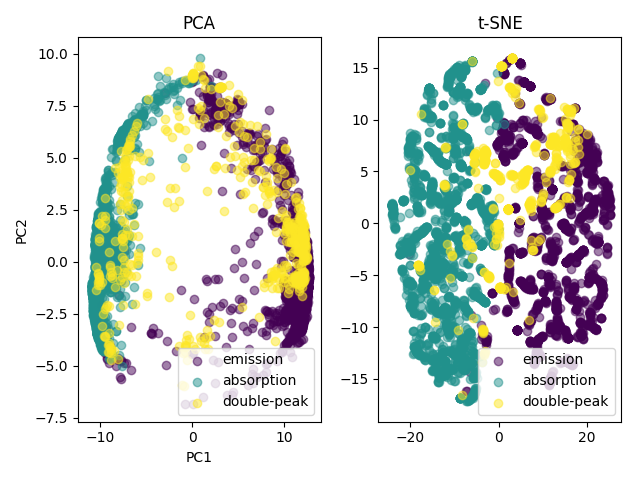

In [34]:
# publication plot
fig, (ax1, ax2) = plt.subplots(1, 2)

cmap = plt.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)

for label, name in enumerate(['emission', 'absorption', 'double-peak']):
    idx = y_ == label
    color = cmap(norm(label))
    ax1.scatter(X_pca[:, 0][idx], X_pca[:, 1][idx], c=color, alpha=0.5, label=name)
    ax2.scatter(X_tsne[:, 0][idx], X_tsne[:, 1][idx], c=color, alpha=0.5, label=name)
    
ax2.set_title('t-SNE')
ax2.legend(loc='lower right')

ax1.set_title('PCA')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend(loc='lower right')

fig.tight_layout();